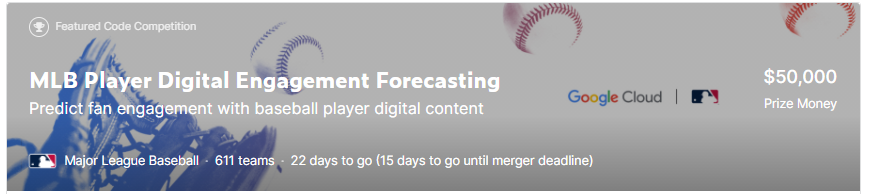

credit to Mrigendra Agrawal I am using his notebook and first predicting a single target and using it as a feature for predicting other targets
https://www.kaggle.com/mrigendraagrawal/fork-of-1-35-lightgbm-ann-2505f2

### 👷勉強のためコードを分解して理解しています。新しい知見を取り入れたい。このコードは元のやつから自分なりに少し修正しています<br>
### もう一つのnotebookは、０から自力で作る方法で、二段構えでやっています。

### このコンペは未来予測なのでいいスコアとっているから勝てるとかそういうものではないやつです。
### もう１つのnotebookは現在47位になっていますが、あてになりません。

In [ ]:
#%%capture internet-onへ
'''
!pip install pandarallel #計算処理を並列化するPandaralellです。
#　少し早くなる程度　https://www.salesanalytics.co.jp/datascience/datascience020/

import gc

import numpy as np
import pandas as pd
from pathlib import Path

from pandarallel import pandarallel
pandarallel.initialize()

BASE_DIR = Path('../input/mlb-player-digital-engagement-forecasting')
train = pd.read_csv(BASE_DIR / 'train.csv')

null = np.nan
true = True
false = False

for col in train.columns:

    if col == 'date': continue

    _index = train[col].notnull()
    train.loc[_index, col] = train.loc[_index, col].parallel_apply(lambda x: eval(x))

    outputs = []
    for index, date, record in train.loc[_index, ['date', col]].itertuples():
        _df = pd.DataFrame(record)
        _df['index'] = index
        _df['date'] = date
        outputs.append(_df)

    outputs = pd.concat(outputs).reset_index(drop=True)

    outputs.to_csv(f'{col}_train.csv', index=False) #=>>>>　これ？カラム分できるじゃん
    outputs.to_pickle(f'{col}_train.pkl') 

    del outputs
    del train[col]
    gc.collect()
    
    ##　停止
    break
'''

### 🧍‍♂️事前処理分解開始。

メモリ不足になるため確認後、コメントアウトしています。

In [ ]:
'''
import gc
import numpy as np
import pandas as pd
from pathlib import Path

null = np.nan
true = True
false = False

BASE_DIR = Path('../input/mlb-player-digital-engagement-forecasting')
train = pd.read_csv(BASE_DIR / 'train.csv')
train.head(5)
'''

In [ ]:
#train.columns

In [ ]:
  #  col = 'nextDayPlayerEngagement'
  #  _index = train[col].notnull()
  #  _index.head(5)

In [ ]:
#len(train.loc[_index, col][:1][0])

In [ ]:
#train.loc[_index, col][:1][0][:500]

In [ ]:
#train.loc[_index, col].apply(lambda x: eval(x)) #まったくなにをしているかわからず

In [ ]:
#len(train.loc[_index, col][:1][0])

In [ ]:
#train.loc[_index, col][:1][0][:500]

In [ ]:
   # outputs = []
   # for index, date, record in train.loc[_index, ['date', col]].itertuples():
   #     print(index,date,record[:100])
   #     break

## <font color="orange">pandasファイルを１行づつ読みたい場合のやり方です</font>
0から作るとこの問題にぶつかります。単純に読もうとすると、１列しか読めなかったり。そこでこのやり方を使うのです。<br>

<font color="#FE2EF7"><u>DataFrame.itertuples()メソッド</u></font><br>
-pandas.DataFrameをfor文でループ処理（イテレーション）する場合、単純にそのままfor文で回すと列名が返ってくるだけなので、繰り返し処理のためのメソッドを使って列ごと・行ごと（一列ずつ・一行ずつ）の値を取得する。<br>
-for row in df.itertuples():<br>

<u><font color="#FE2EF7"> DataFrame.iterrows()メソッド</font></u><br>
-iterrows()メソッドを使うと、1行ずつ、インデックス名（行名）とその行のデータ（pandas.Series型）のタプル(index, Series)を取得できる。<br>
-for index, row in df.iterrows():

In [ ]:
%%capture
'''
for col in train.columns:

    if col == 'date': continue

    _index = train[col].notnull()
    train.loc[_index, col] = train.loc[_index, col].apply(lambda x: eval(x))

    outputs = []
    for index, date, record in train.loc[_index, ['date', col]].itertuples():
        _df = pd.DataFrame(record)
        _df['index'] = index
        _df['date'] = date
        outputs.append(_df)
        break
    break
    '''

%%captureといれておくと、コメント行を実行したときに余計なメッセージがでないのでよく使います。

データはtrain.csvの各カラムで巨大データが入っている<br>
'nextDayPlayerEngagement'のカラムには目的関数が入っている。

In [ ]:
#_df.head(5)

In [ ]:
#col

recordには、辞書形式でデータが格納されている。なのでPandasで取り込める。

In [ ]:
#record[0]

不要データの削除

In [ ]:
#del train
#del outputs
#del record
#del _df
#gc.collect()

### 🧎事前処理分解終了。事前にカラム分読み込んで処理していた。
### 時間があれば、コメント行を外して実行すると勉強になると思います。

### 🎺Training
### 学習部分を分解開始

In [ ]:
import numpy as np
import pandas as pd
import gc
from pathlib import Path
from sklearn.metrics import mean_absolute_error
from datetime import timedelta
from functools import reduce
from tqdm import tqdm
import lightgbm as lgbm
import mlb

In [ ]:
BASE_DIR = Path('../input/mlb-player-digital-engagement-forecasting')
TRAIN_DIR = Path('../input/mlb-pdef-train-dataset')

In [ ]:
players = pd.read_csv(BASE_DIR / 'players.csv')
players

In [ ]:
!rm rosters_train.pkl

In [ ]:
targets = pd.read_pickle(TRAIN_DIR / 'nextDayPlayerEngagement_train.pkl')
targets.to_pickle('nextDayPlayerEngagement_train.pkl')
targets

In [ ]:
scoresx = pd.read_pickle(TRAIN_DIR / 'playerBoxScores_train.pkl')
scoresx

In [ ]:
rosters = pd.read_pickle(TRAIN_DIR / 'rosters_train.pkl')
rosters.to_pickle('rosters_train.pkl')

### 他の人のデータを利用しているので、データを取り込んでpickle化しています。
### もし、データの持ち主がデータセットを削除すると、もう動かなくなってしまいますから。(そんな悪い人はいないと信じたいですが）

### データを公開しておいてスコアがあがり、いざ締め切りの時にデータセットを消されると、
### すべてが台無しになります。エラーになると思います。それに備えてコピーして自分のデータセットにしておくんです。

上の行を実行すると、右のoutput /kaggle/workingの下にファイルができます。<br>
できたファイルの右あたりをクリックするとdownloadの文字がでてきます。<br>
それを押せばダウンロードできます。<br>
データセットを作るのは簡単で、ADD dataをクリックしてアップロードすれば完成です。

In [ ]:
scores = scoresx.groupby(['playerId', 'date']).sum().reset_index()

del scoresx
scores

### <font color="orange">Python でデータ処理するライブラリの定番 Pandas の groupby<br>
groupby は、同じ値を持つデータをまとめて、それぞれの塊に対して共通の操作を行いたい時に使う。<br>
■Aggregation<br>
GroupBy.mean() のように、グループごとに値を求めて表を作るような操作を Aggregation と呼ぶ。このように GroupBy オブジェクトには Aggregation に使う関数が幾つか定義されているが、これらは agg() を使っても実装出来る。<br>
-df.groupby('city').agg(np.mean)<br>
■apply 
    
    
■Transformation

### 結構重要なパート<br>

説明関数が沢山ありますが、余計なものも入っています。余計なものが入っているとスコアが悪くなります。<br>
コメントアウトしているのは、余計な関数だから。<br>
余計な関数かどうかは、LGBMのimportantではうまくいったことがありません。<br>
地道に一個づつ、名前からして余計だなと思うのをコメントアウト、実行しスコアをみています。すごい大変ですが重要な部分です。


In [ ]:
targets_cols = ['playerId', 'target1', 'target2', 'target3', 'target4', 'date']
players_cols = ['playerId', 'primaryPositionName']
rosters_cols = ['playerId', 'teamId', 'status', 'date']
scores_cols = ['playerId', 'battingOrder', 'gamesPlayedBatting', 'flyOuts',
       'groundOuts', 'runsScored', 'doubles', 'triples', 'homeRuns',
       'strikeOuts', 'baseOnBalls', 'intentionalWalks', 'hits', 'hitByPitch',
       'caughtStealing', 'stolenBases', 'atBats', 'groundIntoDoublePlay',
       'groundIntoTriplePlay', 'plateAppearances', 'totalBases', 'rbi',
       'leftOnBase', 'sacBunts',# 'sacFlies', 'catchersInterference',
       'pickoffs', 'gamesPlayedPitching', 'gamesStartedPitching',
       'completeGamesPitching', 'shutoutsPitching', 'winsPitching',
       'airOutsPitching',#lossesPitching', #'flyOutsPitching', ', ###
       'groundOutsPitching', 'runsPitching', 'doublesPitching',
       'triplesPitching', 'homeRunsPitching', 'strikeOutsPitching',
       'baseOnBallsPitching', 'intentionalWalksPitching', 'hitsPitching',
       'hitByPitchPitching', 'atBatsPitching', 'caughtStealingPitching',
       'stolenBasesPitching', 'inningsPitched', 'saveOpportunities',
       'earnedRuns', 'battersFaced', 'outsPitching', 'pitchesThrown', 'balls',
       'strikes', 'hitBatsmen', 'balks', 'wildPitches', 'pickoffsPitching',
       'rbiPitching', 'gamesFinishedPitching', 'inheritedRunners',
       'inheritedRunnersScored', 'catchersInterferencePitching',
       'sacBuntsPitching', 'sacFliesPitching', 'saves',#'holds', 'blownSaves',
       'assists', 'putOuts', 'errors', 'chances', 'date']

feature_cols = ['label_playerId', #'label_primaryPositionName',# 'label_teamId', 
       'battingOrder', 'gamesPlayedBatting', 'flyOuts','label_status', #　'〇label_status',
       'groundOuts', 'runsScored', 'doubles', 'triples', 'homeRuns',
       'strikeOuts', 'baseOnBalls', 'intentionalWalks', 'hits', 'hitByPitch',
       'caughtStealing', 'stolenBases','atBats',  'groundIntoDoublePlay', #○'atBats', ' 'groundIntoDoublePlay',
       'groundIntoTriplePlay', 'plateAppearances', 'totalBases', 'rbi',
       'leftOnBase', #'sacBunts', #'sacFlies', 'catchersInterference', #'leftOnBase', '
       'pickoffs', 'gamesPlayedPitching', 'gamesStartedPitching',
       'completeGamesPitching', 'shutoutsPitching', 'winsPitching',
       #'lossesPitching', 'flyOutsPitching', 'airOutsPitching',###
       'groundOutsPitching', 'runsPitching', 'doublesPitching',
       'triplesPitching', 'homeRunsPitching', 'strikeOutsPitching',
       'baseOnBallsPitching',  'hitsPitching','intentionalWalksPitching',
       'hitByPitchPitching', 'atBatsPitching', 'caughtStealingPitching',
       'stolenBasesPitching', 'inningsPitched', 'saveOpportunities',
       'earnedRuns', 'battersFaced', 'outsPitching', 'pitchesThrown', 'balls',
       'strikes', 'hitBatsmen',  'wildPitches', 'pickoffsPitching','balks',#○'pickoffsPitching', 
       'rbiPitching', 'gamesFinishedPitching', 'inheritedRunners',
       'inheritedRunnersScored', 'catchersInterferencePitching',
       'sacBuntsPitching','saves','sacFliesPitching', #'holds', 'blownSaves',○'sacBuntsPitching', ○'sacFliesPitching' ○ 'sacFliesPitching'
       'assists', 'putOuts', 'errors', 'chances','target1_mean',
 'target1_median',
 'target1_std',
 'target1_min',
 'target1_max',
 'target1_prob',
 'target2_mean',
 'target2_median',
 'target2_std',
 'target2_min',
 'target2_max',
 'target2_prob',
 'target3_mean',
 'target3_median',
 'target3_std',
 'target3_min',
 'target3_max',
 'target3_prob',
 'target4_mean',
 'target4_median',
 'target4_std',
 'target4_min',
 'target4_max',
 'target4_prob']

feature_cols2 = ['label_playerId', 'label_primaryPositionName', 'label_teamId', #needed
                 'label_status', 'battingOrder', 'gamesPlayedBatting', 'flyOuts',
       'groundOuts', 'runsScored', 'doubles', 'triples', 'homeRuns',
       'strikeOuts', 'baseOnBalls', 'hits', 'hitByPitch', 'intentionalWalks', #○'intentionalWalks'
       'caughtStealing', 'stolenBases',  'groundIntoDoublePlay','atBats',#'〇atBats
       'groundIntoTriplePlay', 'plateAppearances', 'totalBases', 'rbi',#○ rbi 
       'leftOnBase','sacBunts',# 'sacFlies', 'catchersInterference',#', 〇leftOnBase'  
       'gamesPlayedPitching', 'gamesStartedPitching','pickoffs',   #〇'pickoffs' 
       'completeGamesPitching', 'shutoutsPitching', 'winsPitching',
       #'airOutsPitching',# lossesPitching', #'flyOutsPitching', '',##〇
       'groundOutsPitching', 'runsPitching', 'doublesPitching',
       'triplesPitching', 'homeRunsPitching', 'strikeOutsPitching',
       'baseOnBallsPitching', 'hitsPitching', 'intentionalWalksPitching',
       'hitByPitchPitching', 'atBatsPitching', 'caughtStealingPitching',
       'stolenBasesPitching', 'inningsPitched', 'saveOpportunities',
       'earnedRuns', 'battersFaced', 'outsPitching', 'pitchesThrown', 'balls',
       'strikes', 'hitBatsmen', 'wildPitches', 'pickoffsPitching',#'balks', 
       'rbiPitching', 'gamesFinishedPitching', 'inheritedRunners', 
       'inheritedRunnersScored', #'catchersInterferencePitching', 
       'sacFliesPitching', 'saves','sacBuntsPitching', #'holds', 'blownSaves'   #〇sacBuntsPitching'
       'assists', 'putOuts', 'errors', 'chances','target1_mean',
 'target1_median',
 'target1_std',
 'target1_min',
 'target1_max',
 'target1_prob',
 'target2_mean',
 'target2_median',
 'target2_std',
 'target2_min',
 'target2_max',
 'target2_prob',
 'target3_mean',
 'target3_median',
 'target3_std',
 'target3_min',
 'target3_max',
 'target3_prob',
 'target4_mean',
 'target4_median',
 'target4_std',
 'target4_min',
 'target4_max',
 'target4_prob',
    'target1']

この説明変数の追加、削除はやりつくして飽きました。他のところをみてみよう。

 これはどこかで事前につくっている。２０６１人分全部。　ken.Millerさん。すごいなあ。
 Millerさんのどこからコピーしたかわすれてしまいましたが、webscrapingというやり方があるみたいです。　https://www.kaggle.com/tensorchoko/web-scraping/

In [ ]:
player_target_stats = pd.read_csv("../input/player-target-stats/player_target_stats.csv")
player_target_stats

In [ ]:
data_names=player_target_stats.columns.values.tolist()
data_names

### <font color="orange">pd.merge(), pd.DataFrame.merge()の使い方</font><br>
pd.merge()関数では第一引数leftと第二引数rightに結合する2つのpandas.DataFrameを指定する。<br>
■結合方法 how<br>
-内部結合（inner_join）: how='inner'<br>
-左結合（left_join）: how='left'<br>
-右結合（right_join）: how='right'<br>
-外部結合（outer_join）: how='outer'<br>

■引数<br>
-明示的に指定する場合は引数onを使う。省略して問題ない場合も明示しておいたほうが分かりやすい。<br>
-引数left_on, right_onでそれぞれのpandas.DataFrameの列名を別々に指定することも可能

In [ ]:
train = targets[targets_cols].merge(players[players_cols], on=['playerId'], how='left')
train

In [ ]:
train = train.merge(rosters[rosters_cols], on=['playerId', 'date'], how='left')
train

In [ ]:
train = train.merge(scores[scores_cols], on=['playerId', 'date'], how='left')
train

In [ ]:
train = train.merge(player_target_stats, how='inner', left_on=["playerId"],right_on=["playerId"])
train

メモリ節約のため不要データは消す。

In [ ]:
del rosters
del scores
player_target_stats
gc.collect()

ここでは文字列を一意の数字に置き換えている。

In [ ]:
player2num = {c: i for i, c in enumerate(train['playerId'].unique())}
player2num[628317] #playerid to 一意な番号を対応させている。

In [ ]:
position2num = {c: i for i, c in enumerate(train['primaryPositionName'].unique())}
position2num

In [ ]:
teamid2num = {c: i for i, c in enumerate(train['teamId'].unique())}
teamid2num

In [ ]:
status2num = {c: i for i, c in enumerate(train['status'].unique())}
status2num

In [ ]:
train['label_playerId'] = train['playerId'].map(player2num)

In [ ]:
train['label_primaryPositionName'] = train['primaryPositionName'].map(position2num) #position2は辞書形式で文字を数字に変換している
train['label_primaryPositionName']

In [ ]:
train['label_teamId'] = train['teamId'].map(teamid2num)
train['label_teamId']

In [ ]:
train['label_status'] = train['status'].map(status2num)
train['label_status']

trainデータとvalidデータにわけている。<br>

In [ ]:
train_X = train[feature_cols]
train_y = train[['target1', 'target2', 'target3', 'target4']]

_index = (train['date'] < 20210401)
x_train1 = train_X.loc[_index].reset_index(drop=True)
y_train1 = train_y.loc[_index].reset_index(drop=True)
x_valid1 = train_X.loc[~_index].reset_index(drop=True)
y_valid1 = train_y.loc[~_index].reset_index(drop=True)

In [ ]:
def fit_lgbm(x_train, y_train, x_valid, y_valid, params: dict=None, verbose=100):
    oof_pred = np.zeros(len(y_valid), dtype=np.float32)
    model = lgbm.LGBMRegressor(**params) #回帰型lgb
    model.fit(x_train, y_train, 
        eval_set=[(x_valid, y_valid)],  
        early_stopping_rounds=verbose, 
        verbose=verbose)
    oof_pred = model.predict(x_valid)
    score = mean_absolute_error(oof_pred, y_valid)
    print('mae:', score)
    return oof_pred, model, score

### 2021/7/12 metricをl1=>l2に変更してみる。

In [ ]:
prm1={'objective': 'mae',
 'metric': 'l2',
 'feature_pre_filter': False,
 'lambda_l1': 1.146853310507615e-06,
 'lambda_l2': 0.5249994991618241,
 'num_leaves': 255,
 'feature_fraction': 0.48000000000000004,
 'bagging_fraction': 0.4073948386925109,
 'bagging_freq': 6,
 'min_child_samples': 5,
 'num_iterations': 1000,
 'early_stopping_round': 50,#None,
 'n_estimators': 5000,#3633,
 'learning_rate': 0.08} #0.08046301304430488}

In [ ]:
oof1, model1, score1 = fit_lgbm(
    x_train1, y_train1['target1'],
    x_valid1, y_valid1['target1'],
    prm1
 )

In [ ]:
#del train
del x_train1
#del x_train2
del y_train1
#del y_train2
del x_valid1
#del x_valid2
del y_valid1
#del y_valid2
del train_X
del train_y
gc.collect()

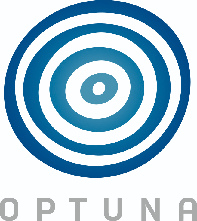

### optunaはlightGBMのハイパーパラメータでいいものをさがしてくれる味方です。

### optuna一度にやると処理時間　軽く９時間オーバーです。今はコメントアウトしています。

### やったことない人は、コメントアウトはずしてうごかしてみてください。

In [ ]:
import optuna 
import optuna.integration.lightgbm as lgbo
import lightgbm as lgb

params = { 'objective': 'mae', 'metric': 'mae' } 
#lgb_train1 = lgb.Dataset(x_train1, y_train1['target1'])
#lgb_valid1 = lgb.Dataset(x_valid1, y_valid1['target1'])
#model1 = lgbo.train(params, lgb_train1, valid_sets=[lgb_valid1], verbose_eval=100)
#model1.params = {'n_estimators': 3633, 'learning_rate': 0.08046301304430488}
#model1.params

In [ ]:
train_X = train[feature_cols2]
train_y = train[['target1', 'target2', 'target3', 'target4']]

_index = (train['date'] < 20210401)
x_train2 = train_X.loc[_index].reset_index(drop=True)
y_train2 = train_y.loc[_index].reset_index(drop=True)
x_valid2 = train_X.loc[~_index].reset_index(drop=True)
y_valid2 = train_y.loc[~_index].reset_index(drop=True)

In [ ]:
del train
del train_X
del train_y
gc.collect()

In [ ]:

#lgb_train2 = lgb.Dataset(x_train2, y_train2['target2'])
#lgb_valid2 = lgb.Dataset(x_valid2, y_valid2['target2'])
#model2 = lgbo.train(params, lgb_train2, valid_sets=[lgb_valid2], verbose_eval=100)
#model2.params ={'n_estimators': 80, 'learning_rate': 0.1}
#model2.params

In [ ]:

#lgb_train2 = lgb.Dataset(x_train2, y_train2['target3'])
#lgb_valid2 = lgb.Dataset(x_valid2, y_valid2['target3'])
#model3 = lgbo.train(params, lgb_train2, valid_sets=[lgb_valid2], verbose_eval=100)
#model3.params ={'n_estimators': 9868, 'learning_rate': 0.10528150510326864}
#model3.params

In [ ]:

#lgb_train2 = lgb.Dataset(x_train2, y_train2['target4'])
#lgb_valid2 = lgb.Dataset(x_valid2, y_valid2['target4'])
#model4 = lgbo.train(params, lgb_train2, valid_sets=[lgb_valid2], verbose_eval=100)
#model4.params = {'n_estimators': 9868, 'learning_rate': 0.10528150510326864}
#model4.params

### パラメータ設定(Optunaで出力されたもの。一部は手入力）
### n_estimators,learning_rateはOptunaで出力されない。これをどうやって決めるかわからない。Gridserchとかでやるのかなあ。

In [ ]:

prm2={'objective': 'mae',
 'metric': 'l2',
 'feature_pre_filter': False,
 'lambda_l1': 0.023375452815085587,
 'lambda_l2': 0.02276139446807019,
 'num_leaves': 8,
 'feature_fraction': 0.92,
 'bagging_fraction': 0.6495829305086558,
 'bagging_freq': 3,
 'min_child_samples': 20,
 'num_iterations': 1000,
 'early_stopping_round': 50,#None,
 'n_estimators': 1000,#80, 
 'learning_rate': 0.1}#0.1}

prm3={'objective': 'mae',
 'metric': 'l2',
 'feature_pre_filter': False,
 'lambda_l1': 0.0,
 'lambda_l2': 0.0,
 'num_leaves': 49,
 'feature_fraction': 0.6,
 'bagging_fraction': 1.0,
 'bagging_freq': 0,
 'min_child_samples': 20,
 'num_iterations': 1000,
 'early_stopping_round': 50,#None,
 'n_estimators': 10000,#9868,
 'learning_rate': 0.05} #0.0528150510326864}

prm4 ={'objective': 'mae',
 'metric': 'l2',
 'feature_pre_filter': False,
 'lambda_l1': 0.0,
 'lambda_l2': 0.0,
 'num_leaves': 254,
 'feature_fraction': 0.4,
 'bagging_fraction': 1.0,
 'bagging_freq': 0,
 'min_child_samples': 50,
 'num_iterations': 1000,
 'early_stopping_round': 50,#None,
 'n_estimators': 1000, #9868, 
 'learning_rate': 0.05}#0528150510326864,}

In [ ]:


# training lightgbm

params1 = {'objective':'mae','reg_alpha': 0.14947461820098767, 'reg_lambda': 0.10185644384043743, 'n_estimators': 3633, 'learning_rate': 0.08046301304430488, 'num_leaves': 674, 'feature_fraction': 0.9101240539122566, 'bagging_fraction': 0.9884451442950513, 'bagging_freq': 8, 'min_child_samples': 51}

params2 = {
 'objective':'mae',
 'reg_alpha': 0.1,
 'reg_lambda': 0.1, 
 'n_estimators': 80,
 'learning_rate': 0.1,
 'random_state': 42,
 "num_leaves": 22
}

params4 = {'objective':'mae','reg_alpha': 0.016468100279441976, 'reg_lambda': 0.09128335764019105, 'n_estimators': 9868, 'learning_rate': 0.10528150510326864, 'num_leaves': 157, 'feature_fraction': 0.5419185713426886, 'bagging_fraction': 0.2637405128936662, 'bagging_freq': 19, 'min_child_samples': 71}


params = {
 'objective':'mae',
 'reg_alpha': 0.1,
 'reg_lambda': 0.1, 
 'n_estimators': 10000,
 'learning_rate': 0.1,
 'random_state': 42,
 "num_leaves": 100
}


oof2, model2, score2 = fit_lgbm(
    x_train2, y_train2['target2'],
    x_valid2, y_valid2['target2'],
    prm2
)

oof3, model3, score3 = fit_lgbm(
    x_train2, y_train2['target3'],
    x_valid2, y_valid2['target3'],
    prm3
)

oof4, model4, score4 = fit_lgbm(
    x_train2, y_train2['target4'],
    x_valid2, y_valid2['target4'],
    prm4
)
score = (score1+score2+score3+score4) / 4
print(f'score: {score}')

In [ ]:

#del x_train1
del x_train2
#del y_train1
del y_train2
#del x_valid1
del x_valid2
#del y_valid1
del y_valid2

### 📲予測

In [ ]:
players_cols = ['playerId', 'primaryPositionName']
rosters_cols = ['playerId', 'teamId', 'status']
scores_cols = ['playerId', 'battingOrder', 'gamesPlayedBatting', 'flyOuts',
       'groundOuts', 'runsScored', 'doubles', 'triples', 'homeRuns',
       'strikeOuts', 'baseOnBalls', 'intentionalWalks', 'hits', 'hitByPitch',
       'caughtStealing', 'stolenBases', 'atBats','groundIntoDoublePlay',
       'groundIntoTriplePlay', 'plateAppearances', 'totalBases', 'rbi',
       'leftOnBase', 'sacBunts',# 'sacFlies', 'catchersInterference',
       'pickoffs', 'gamesPlayedPitching', 'gamesStartedPitching',
       'completeGamesPitching', 'shutoutsPitching', 'winsPitching',
       'airOutsPitching',#'lossesPitching', #'flyOutsPitching', '###
       'groundOutsPitching', 'runsPitching', 'doublesPitching',
       'triplesPitching', 'homeRunsPitching', 'strikeOutsPitching',
       'baseOnBallsPitching', 'intentionalWalksPitching', 'hitsPitching',
       'hitByPitchPitching', 'atBatsPitching', 'caughtStealingPitching',
       'stolenBasesPitching', 'inningsPitched', 'saveOpportunities',
       'earnedRuns', 'battersFaced', 'outsPitching', 'pitchesThrown', 'balls',
       'strikes', 'hitBatsmen', 'balks', 'wildPitches', 'pickoffsPitching',
       'rbiPitching', 'gamesFinishedPitching', 'inheritedRunners',
       'inheritedRunnersScored', 'catchersInterferencePitching',
       'sacBuntsPitching', 'sacFliesPitching', 'saves', #'holds', 'blownSaves',
       'assists', 'putOuts', 'errors', 'chances']

null = np.nan
true = True
false = False

In [ ]:
import pandas as pd
import numpy as np
from datetime import timedelta
from tqdm import tqdm
import gc
from functools import reduce
from sklearn.model_selection import StratifiedKFold

ROOT_DIR = "../input/mlb-player-digital-engagement-forecasting"

#=======================#
def flatten(df, col):
    du = (df.pivot(index="playerId", columns="EvalDate", 
               values=col).add_prefix(f"{col}_").
      rename_axis(None, axis=1).reset_index())
    return du

#============================#
def reducer(left, right):
    return left.merge(right, on="playerId")

#========================

TGTCOLS = ["target1","target2","target3","target4"]
def train_lag(df, lag=1):
    dp = df[["playerId","EvalDate"]+TGTCOLS].copy()
    dp["EvalDate"]  =dp["EvalDate"] + timedelta(days=lag) 
    df = df.merge(dp, on=["playerId", "EvalDate"], suffixes=["",f"_{lag}"], how="left")
    return df

#=================================
def test_lag(sub):
    sub["playerId"] = sub["date_playerId"].apply(lambda s: int(  s.split("_")[1]  ) )
    assert sub.date.nunique() == 1
    dte = sub["date"].unique()[0]
    
    eval_dt = pd.to_datetime(dte, format="%Y%m%d")
    dtes = [eval_dt + timedelta(days=-k) for k in LAGS]
    mp_dtes = {eval_dt + timedelta(days=-k):k for k in LAGS}
    
    sl = LAST.loc[LAST.EvalDate.between(dtes[-1], dtes[0]), ["EvalDate","playerId"]+TGTCOLS].copy()
    sl["EvalDate"] = sl["EvalDate"].map(mp_dtes)
    du = [flatten(sl, col) for col in TGTCOLS]
    du = reduce(reducer, du)
    return du, eval_dt
    #
#===============

### <font color="orange"> Pandas.pivot</font><br>
列方向に並んだデータを行方向に並べ替えたり、行方向に並んだデータを列方向に並べ替えたりして、データの構造を再形成できる。<br>
■列から行へピボット: stack()<br>
-stack()メソッドを呼ぶと列方向に並んでいたデータが行方向に並べ替えられる。縦に積み重なる（= stack）イメージ。<br>
■行から列へピボット: unstack()<br>
-stack()で取得したpandas.Seriesからunstack()を呼ぶと元に戻る。行方向に並んでいたデータが列方向に並べ替えられる。<br>

＜例＞
クロス集計したい時や、ちょっとややこしいグラフをつくる際などに必要になります。<br>
name blood_type   class state<br>
0   Alice          A    high    NY<br>
1     Bob          B  middle    OH<br>
2   Chris         AB     low    ND<br>
3   David          B     low    OH<br>
4    Evan          O     low    NY<br>
5  Fabian          O  middle    OK<br>
6    Gari          A    high    DC<br>

<n>In [4]: df.pivot(index="class",columns="state",values="name")</n><br>
Out[4]:<br>
state     DC     ND     NY     OH      OK<br>
class                                    <br>
high    Gari    NaN  Alice    NaN     NaN<br>
low      NaN  Chris   Evan  David     NaN<br>
middle   NaN    NaN    NaN    Bob  Fabian<br>

In [ ]:
tr = pd.read_csv("../input/mlb-data/target.csv") #外部データ
print(tr.shape)
gc.collect()

tr["EvalDate"] = pd.to_datetime(tr["EvalDate"])
tr["EvalDate"] = tr["EvalDate"] + timedelta(days=-1)
tr["EvalYear"] = tr["EvalDate"].dt.year
tr

In [ ]:
MED_DF = tr.groupby(["playerId","EvalYear"])[TGTCOLS].median().reset_index()
MED_DF

In [ ]:
MEDCOLS = ["tgt1_med","tgt2_med", "tgt3_med", "tgt4_med"]
MED_DF.columns = ["playerId","EvalYear"] + MEDCOLS
MED_DF.columns

In [ ]:
LAGS = list(range(1,21))
FECOLS = [f"{col}_{lag}" for lag in reversed(LAGS) for col in TGTCOLS]
FECOLS

In [ ]:
for lag in tqdm(LAGS):
    tr = train_lag(tr, lag=lag)
    gc.collect()
    
tr

In [ ]:
tr = tr.sort_values(by=["playerId", "EvalDate"])
print(tr.shape)
tr = tr.dropna()
print(tr.shape)
tr = tr.merge(MED_DF, on=["playerId","EvalYear"])
gc.collect()
tr

In [ ]:
from memory_profiler import profile
def large_integer_list():
    return [i for i in range(0,10000000)]

sum(large_integer_list())

### メモリ使用状況確認

In [ ]:
import sys
print("{}{:>25}{}{:>10}{}".format('|','Variable Name','|','memory','|'))
for var_name in dir():
    if not var_name.startswith("_") and sys.getsizeof(eval(var_name)) > 10000:
        print("{}{:>25}{}{:>10}{}".format('|',var_name,'|',sys.getsizeof(eval(var_name)),'|'))

In [ ]:
X = tr[FECOLS+MEDCOLS].values
y = tr[TGTCOLS].values
cl = tr["playerId"].values
tr

In [ ]:
NFOLDS = 6
skf = StratifiedKFold(n_splits=NFOLDS)
folds = skf.split(X, cl)
folds = list(folds)

import tensorflow as tf
import tensorflow.keras.layers as L
import tensorflow.keras.models as M
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

tf.random.set_seed(777)

### モデルANN

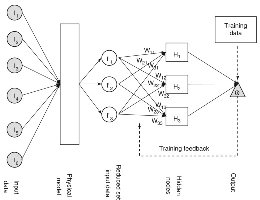

ANNは、単純な計算単位（ノードとも呼ばれます）のセットです。
高度に相互接続されています。 ANNはさまざまなアプリケーションに使用されてきました。
統計的手法が伝統的に採用されている場所。それらはで使用されています。

In [ ]:
def make_model(n_in):
    inp = L.Input(name="inputs", shape=(n_in,))
    x = L.Dense(50, activation="relu", name="d1")(inp)
    x = L.Dense(50, activation="relu", name="d2")(x)
    preds = L.Dense(4, activation="linear", name="preds")(x)
    
    model = M.Model(inp, preds, name="ANN")
    model.compile(loss="mean_absolute_error", optimizer="adam")
    return model

In [ ]:
net = make_model(X.shape[1])
print(net.summary())

学習をやってみる前に最適な学習率の変化の計画を立てておくことは非常に困難です。
最初は大きめの値でどんどん学習して、それではうまくいかなくなった段階で徐々に下げるということをやりたくなります。

そして、 kerasにはそのためのコールバックの、ReduceLROnPlateau というのが用意されています。
監視する評価値、何エポック改善しなかったら学習率を落とすか、その変化の割合、最小値などを指定すると、
学習の進みに応じて調整してくれます。

In [ ]:
oof = np.zeros(y.shape)
nets = []
for idx in range(NFOLDS):
    print("FOLD:", idx)
    tr_idx, val_idx = folds[idx]
    ckpt = ModelCheckpoint(f"w{idx}.h5", monitor='val_loss', verbose=1, save_best_only=True,mode='min')
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,patience=3, min_lr=0.0005)
    es = EarlyStopping(monitor='val_loss', patience=6)
    reg = make_model(X.shape[1])
    reg.fit(X[tr_idx], y[tr_idx], epochs=15, batch_size=35_000, validation_data=(X[val_idx], y[val_idx]),#epoch 10=>15
            verbose=1, callbacks=[ckpt, reduce_lr, es])
    reg.load_weights(f"w{idx}.h5")
    oof[val_idx] = reg.predict(X[val_idx], batch_size=50_000, verbose=1)
    nets.append(reg)
    gc.collect()
 

In [ ]:
mae = mean_absolute_error(y, oof)
mse = mean_squared_error(y, oof, squared=False)
print("mae:", mae)
print("mse:", mse)

# Historical information to use in prediction time
bound_dt = pd.to_datetime("2021-01-01")
LAST = tr.loc[tr.EvalDate>bound_dt].copy()

LAST_MED_DF = MED_DF.loc[MED_DF.EvalYear==2021].copy()
LAST_MED_DF.drop("EvalYear", axis=1, inplace=True)
del tr

#"""
import mlb
FE = []; SUB = [];

# envセクション

In [ ]:
import copy

env = mlb.make_env() # initialize the environment
iter_test = env.iter_test() # iterator which loops over each date in test set

In [ ]:
for (test_df, sample_prediction_df) in iter_test: # make predictions here
    
    sub = copy.deepcopy(sample_prediction_df.reset_index())
    sample_prediction_df = copy.deepcopy(sample_prediction_df.reset_index(drop=True))
    
    # LGBM summit
    # creat dataset
    sample_prediction_df['playerId'] = sample_prediction_df['date_playerId']\
                                        .map(lambda x: int(x.split('_')[1]))
    # Dealing with missing values
    if test_df['rosters'].iloc[0] == test_df['rosters'].iloc[0]:
        test_rosters = pd.DataFrame(eval(test_df['rosters'].iloc[0]))
    else:
        test_rosters = pd.DataFrame({'playerId': sample_prediction_df['playerId']})
        for col in rosters.columns:
            if col == 'playerId': continue
            test_rosters[col] = np.nan
            
    if test_df['playerBoxScores'].iloc[0] == test_df['playerBoxScores'].iloc[0]:
        test_scores = pd.DataFrame(eval(test_df['playerBoxScores'].iloc[0]))
    else:
        test_scores = pd.DataFrame({'playerId': sample_prediction_df['playerId']})
        for col in scores.columns:
            if col == 'playerId': continue
            test_scores[col] = np.nan
    test_scores = test_scores.groupby('playerId').sum().reset_index()
    test = sample_prediction_df[['playerId']].copy()
    test = test.merge(players[players_cols], on='playerId', how='left')
    test = test.merge(test_rosters[rosters_cols], on='playerId', how='left')
    test = test.merge(test_scores[scores_cols], on='playerId', how='left')
    test = test.merge(player_target_stats, how='inner', left_on=["playerId"],right_on=["playerId"])
    

    test['label_playerId'] = test['playerId'].map(player2num)
    test['label_primaryPositionName'] = test['primaryPositionName'].map(position2num)
    test['label_teamId'] = test['teamId'].map(teamid2num)
    test['label_status'] = test['status'].map(status2num)
    
    test_X = test[feature_cols]
    # predict
    pred1 = model1.predict(test_X)
    test['target1'] = np.clip(pred1,0,100)
    test_X = test[feature_cols2]

    pred2 = model2.predict(test_X)
    pred3 = model3.predict(test_X)
    pred4 = model4.predict(test_X)
    
    # merge submission
    sample_prediction_df['target1'] = np.clip(pred1, 0, 100)
    sample_prediction_df['target2'] = np.clip(pred2, 0, 100)
    sample_prediction_df['target3'] = np.clip(pred3, 0, 100)
    sample_prediction_df['target4'] = np.clip(pred4, 0, 100)
    sample_prediction_df = sample_prediction_df.fillna(0.)
    del sample_prediction_df['playerId']
    # TF summit
    # Features computation at Evaluation Date
    sub_fe, eval_dt = test_lag(sub)
    sub_fe = sub_fe.merge(LAST_MED_DF, on="playerId", how="left")
    sub_fe = sub_fe.fillna(0.)
    
    _preds = 0.
    for reg in nets:
        _preds += reg.predict(sub_fe[FECOLS + MEDCOLS]) / NFOLDS
    sub_fe[TGTCOLS] = np.clip(_preds, 0, 100)
    sub.drop(["date"]+TGTCOLS, axis=1, inplace=True)
    sub = sub.merge(sub_fe[["playerId"]+TGTCOLS], on="playerId", how="left")
    sub.drop("playerId", axis=1, inplace=True)
    sub = sub.fillna(0.)
    # Blending
    blend = pd.concat(
        [sub[['date_playerId']],
        (0.1*sub.drop('date_playerId', axis=1) + 0.9*sample_prediction_df.drop('date_playerId', axis=1))], #0.1,0.9
        axis=1
    )
    env.predict(blend)
    # Update Available information
    sub_fe["EvalDate"] = eval_dt
    #sub_fe.drop(MEDCOLS, axis=1, inplace=True)
    LAST = LAST.append(sub_fe)
    LAST = LAST.drop_duplicates(subset=["EvalDate","playerId"], keep="last")

This version of the API is not optimized and should not be used to estimate the runtime of your code on the hidden test set.<br>
のメッセージはどうやら意味はあまりないようです。

### 分解

In [ ]:
pd.concat(
    [sub[['date_playerId']],
    (sub.drop('date_playerId', axis=1) + sample_prediction_df.drop('date_playerId', axis=1)) / 2],
    axis=1
)

In [ ]:
sample_prediction_df

eval関数を使って結果を変数に格納したい場合には、

変数 = eval("式")

In [ ]:
 pd.DataFrame(eval(test_df['playerBoxScores'].iloc[0]))

evalを使わないと以下のようになる。pandasに無理やりいれようとするとエラーになりました。

In [ ]:
test_df['playerBoxScores'].iloc[0][:500]

In [ ]:
pd.DataFrame(pred1)

NumPy配列ndarrayを任意の最小値・最大値に収めるclip<br>
1183行目の負値が0になっている。

In [ ]:
pd.DataFrame(np.clip(pred1, 0, 100))

In [ ]:
sub_fe

In [ ]:
[sub[['date_playerId']],
        (0.1*sub.drop('date_playerId', axis=1))]

In [ ]:
[(0.9*sample_prediction_df.drop('date_playerId', axis=1))]

### このconcatでの割合がポイントになってくる。
### だいたい複数のモデルの結果を最後に統合するアンサンブルというのをやっています。
### これだと２つのモデルの結果を、よさげなモデルの方の比率（下の例だと0.8倍）しています。

In [ ]:
pd.concat(
        [sub[['date_playerId']],
        (0.2*sub.drop('date_playerId', axis=1) + 0.8*sample_prediction_df.drop('date_playerId', axis=1))],
        axis=1)